In [1]:
!apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-securi

In [2]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount = True)

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/My Drive/LDS9_K265_DinhVietHa//LDS9_K265_DinhVietHa_Cuoi_ky/'

/content/gdrive/My Drive/LDS9_K265_DinhVietHa/LDS9_K265_DinhVietHa_Cuoi_ky


In [4]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

In [5]:
spark = SparkSession \
  .builder \
  .master("local[*]")\
  .appName("fake_real") \
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", "10g") \
  .config("spark.driver.memory", "10g")\
  .config("spark.sql.shuffle.partitions" , "800") \
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","10g")\
  .getOrCreate()
spark

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [19]:
fake_data = pd.read_csv("./Du lieu cung cap/fake-and-real-news-dataset/Fake.csv", header=0, encoding='utf-8')

In [20]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [21]:
fake_df = spark.createDataFrame(fake_data)

In [22]:
fake_df.show(5)

+--------------------+--------------------+-------+-----------------+
|               title|                text|subject|             date|
+--------------------+--------------------+-------+-----------------+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|
| Trump Is So Obse...|On Christmas day,...|   News|December 29, 2017|
| Pope Francis Jus...|Pope Francis used...|   News|December 25, 2017|
+--------------------+--------------------+-------+-----------------+
only showing top 5 rows



In [23]:
real_data = pd.read_csv("./Du lieu cung cap/fake-and-real-news-dataset/True.csv", header=0, encoding='utf-8')

In [24]:
real_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [25]:
real_df = spark.createDataFrame(real_data)

In [46]:
real_df.show(5)

+--------------------+--------------------+------------+------------------+-----+
|               title|                text|     subject|              date|label|
+--------------------+--------------------+------------+------------------+-----+
|As U.S. budget fi...|WASHINGTON (Reute...|politicsNews|December 31, 2017 |    0|
|U.S. military to ...|WASHINGTON (Reute...|politicsNews|December 29, 2017 |    0|
|Senior U.S. Repub...|WASHINGTON (Reute...|politicsNews|December 31, 2017 |    0|
|FBI Russia probe ...|WASHINGTON (Reute...|politicsNews|December 30, 2017 |    0|
|Trump wants Posta...|SEATTLE/WASHINGTO...|politicsNews|December 29, 2017 |    0|
+--------------------+--------------------+------------+------------------+-----+
only showing top 5 rows



In [27]:
from pyspark.sql.functions import lit,concat,col
from pyspark.sql.functions import isnan, when, count

In [28]:
fake_df = fake_df.withColumn("label", lit(1))
real_df = real_df.withColumn("label", lit(0))

In [47]:
fake_df.show(5,truncate=50)
real_df.show(5,truncate=50)

+--------------------------------------------------+--------------------------------------------------+-------+-----------------+-----+
|                                             title|                                              text|subject|             date|label|
+--------------------------------------------------+--------------------------------------------------+-------+-----------------+-----+
| Donald Trump Sends Out Embarrassing New Year’s...|Donald Trump just couldn t wish all Americans a...|   News|December 31, 2017|    1|
| Drunk Bragging Trump Staffer Started Russian C...|House Intelligence Committee Chairman Devin Nun...|   News|December 31, 2017|    1|
| Sheriff David Clarke Becomes An Internet Joke ...|On Friday, it was revealed that former Milwauke...|   News|December 30, 2017|    1|
| Trump Is So Obsessed He Even Has Obama’s Name ...|On Christmas day, Donald Trump announced that h...|   News|December 29, 2017|    1|
| Pope Francis Just Called Out Donald Trump Duri

In [30]:
fake_df.count()

23481

In [31]:
real_df.count()

21417

Combine the 2 dataframes fake and real

In [32]:
df = fake_df.union(real_df)
df.count()

44898

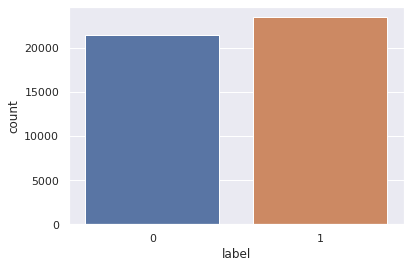

In [33]:
sns.set(style="darkgrid")
sns.countplot(data=df.select('label').toPandas(), x='label')
plt.show()

The fake (1) and real (0) news amounts are not considerably different. There are more fake news than real news.

In [34]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas().T

,0
title,0
text,0
subject,0
date,0
label,0


In [35]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().T

,0
title,0
text,0
subject,0
date,0
label,0


There is no null or nan data.

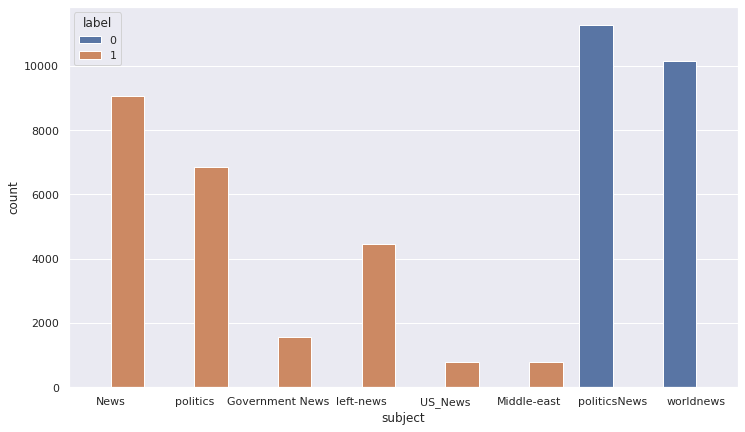

In [43]:
plt.figure(figsize=(12,7))
sns.set(style="darkgrid")
sns.countplot(data=df.toPandas(), x='subject', hue="label")
plt.show()

politicsNews has the most articles, followed by worldnews, News and politics. These subjects outnumber the remaining.

The real news only accounts 2 subjects politicNews and worldnews.

# Data Preprocessing

In [51]:
from pyspark.sql.functions import regexp_replace, lower, udf

In [95]:
from pyspark.sql.types import StringType

In [52]:
import re

#### Clean the data: 
* lowercase the words
* remove special character, links, squared brackets, number in words, punctuation
* remove the word Reuters as it appears in almost any real news, it wil be too obvious for the model, and we want to focus more on the content

Create a text cleaning function

In [2]:
import re

In [87]:
# with reference found online
def clean_text(text):
  text = re.sub('.Reuters','',text)
  text = str(text).lower()
  text = re.sub('[^\w\s]','',text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  return text

We will use "title" and "text" to predict the label.

We will combine "title" and "text" into one column.

In [90]:
df_text = df.select("title","text","label")

In [91]:
df_text = df_text.withColumn("text_new", concat(col("title"), lit(" "), col("text")).alias("text"))

In [92]:
df_text = df_text.drop('title','text')

In [93]:
df_text.show(5)

+-----+--------------------+
|label|            text_new|
+-----+--------------------+
|    1| Donald Trump Sen...|
|    1| Drunk Bragging T...|
|    1| Sheriff David Cl...|
|    1| Trump Is So Obse...|
|    1| Pope Francis Jus...|
+-----+--------------------+
only showing top 5 rows



In [98]:
df_text.printSchema()

root
 |-- label: integer (nullable = false)
 |-- text_new: string (nullable = true)



In [96]:
udfclean = udf(clean_text, StringType())

In [99]:
df_clean = df_text.withColumn("text_clean", udfclean(df_text.text_new))

In [101]:
df_clean.show(10, truncate=50)

+-----+--------------------------------------------------+--------------------------------------------------+
|label|                                          text_new|                                        text_clean|
+-----+--------------------------------------------------+--------------------------------------------------+
|    1| Donald Trump Sends Out Embarrassing New Year’s...| donald trump sends out embarrassing new years ...|
|    1| Drunk Bragging Trump Staffer Started Russian C...| drunk bragging trump staffer started russian c...|
|    1| Sheriff David Clarke Becomes An Internet Joke ...| sheriff david clarke becomes an internet joke ...|
|    1| Trump Is So Obsessed He Even Has Obama’s Name ...| trump is so obsessed he even has obamas name c...|
|    1| Pope Francis Just Called Out Donald Trump Duri...| pope francis just called out donald trump duri...|
|    1| Racist Alabama Cops Brutalize Black Boy While ...| racist alabama cops brutalize black boy while ...|
|    1| Fr

In [105]:
df_clean.count()

44898

In [112]:
df_clean = df_clean.select("label","text_clean")

#### Feature transformation



In [113]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml.feature import CountVectorizer, IDF, StringIndexer

In [114]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector

In [117]:
tokenizer = Tokenizer(inputCol="text_clean", outputCol="token_text")
stopremove = StopWordsRemover(inputCol="token_text", outputCol="stop_tokens")
count_vec = CountVectorizer(inputCol="stop_tokens", outputCol="c_vec")
idf = IDF(inputCol="c_vec", outputCol="tf_idf")
# class_to_num = StringIndexer(inputCol="Rating", outputCol="label")

In [118]:
clean_up = VectorAssembler(inputCols=["tf_idf"], outputCol="features")

## Pipeline

In [119]:
from pyspark.ml import Pipeline

In [120]:
data_prep_pipe = Pipeline(stages = [tokenizer,
                                   stopremove,count_vec,idf,clean_up])

In [121]:
cleaner = data_prep_pipe.fit(df_clean)

In [122]:
clean_data = cleaner.transform(df_clean)

## The Model

First I will try with the Naive Bayes. 

In [123]:
from pyspark.ml.classification import NaiveBayes

In [124]:
nb = NaiveBayes()

## Training and Evaluation

In [125]:
clean_data.show(5)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|label|          text_clean|          token_text|         stop_tokens|               c_vec|              tf_idf|            features|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    1| donald trump sen...|[, donald, trump,...|[, donald, trump,...|(207438,[0,2,4,5,...|(207438,[0,2,4,5,...|(207438,[0,2,4,5,...|
|    1| drunk bragging t...|[, drunk, braggin...|[, drunk, braggin...|(207438,[0,1,2,3,...|(207438,[0,1,2,3,...|(207438,[0,1,2,3,...|
|    1| sheriff david cl...|[, sheriff, david...|[, sheriff, david...|(207438,[0,2,5,6,...|(207438,[0,2,5,6,...|(207438,[0,2,5,6,...|
|    1| trump is so obse...|[, trump, is, so,...|[, trump, obsesse...|(207438,[0,2,3,4,...|(207438,[0,2,3,4,...|(207438,[0,2,3,4,...|
|    1| pope francis jus...|[, pope, francis,...|[, pope, fran

In [126]:
clean_data = clean_data.select(["label","features"])

In [127]:
clean_data.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|(207438,[0,2,4,5,...|
|    1|(207438,[0,1,2,3,...|
|    1|(207438,[0,2,5,6,...|
|    1|(207438,[0,2,3,4,...|
|    1|(207438,[0,1,2,3,...|
+-----+--------------------+
only showing top 5 rows



In [128]:
(training, testing) = clean_data.randomSplit([0.7,0.3])

In [129]:
training.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|14951|
|    1|16400|
+-----+-----+



In [130]:
testing.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0| 6466|
|    1| 7081|
+-----+-----+



In [131]:
predictor = nb.fit(training)

In [132]:
test_results = predictor.transform(testing) 

In [133]:
test_results.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    1|      (207438,[],[])|[-0.7404648861272...|[0.47689216342933...|       1.0|
|    1|(207438,[0,1,2,3,...|[-12614.401800787...|[8.60092837254140...|       1.0|
|    1|(207438,[0,1,2,3,...|[-16434.310223663...|           [0.0,1.0]|       1.0|
|    1|(207438,[0,1,2,3,...|[-62619.361222827...|           [0.0,1.0]|       1.0|
|    1|(207438,[0,1,2,3,...|[-41295.249330352...|           [0.0,1.0]|       1.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



Create a confusion matrix

In [134]:
test_results.groupBy("label","prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  245|
|    0|       0.0| 6212|
|    1|       1.0| 6836|
|    0|       1.0|  254|
+-----+----------+-----+



Evaluate the model

In [135]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [136]:
acc_val = MulticlassClassificationEvaluator()
acc = acc_val.evaluate(test_results)
print("Accuracy of model at predicting: {}".format(acc))

Accuracy of model at predicting: 0.9631641468554049


The Naive Bayes model return high accuracy (96%) -> good model.

### Logistic Regression

In [137]:
from pyspark.ml.classification import LogisticRegression

In [138]:
lg = LogisticRegression(maxIter=20,regParam=0.3,elasticNetParam=0)

In [139]:
predictor_2 = lg.fit(training)

In [140]:
test_results_2 = predictor_2.transform(testing)

In [141]:
test_results_2.groupBy("label","prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  229|
|    0|       0.0| 6417|
|    1|       1.0| 6852|
|    0|       1.0|   49|
+-----+----------+-----+



In [142]:
test_results_2.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 6646|
|       1.0| 6901|
+----------+-----+



In [143]:
acc_val = MulticlassClassificationEvaluator()
acc_2 = acc_val.evaluate(test_results_2)
print("Accuracy of model at predicting: {}".format(acc_2))

Accuracy of model at predicting: 0.9794876158667305


The logistic regression model has higher accuracy of ~ 98% compared to the Naive Bayes model. --> very good model.